In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

https://www.kaggle.com/code/dariussingh/nfl-visualizing-player-tracking-data

In [2]:
# import dependencies
import numpy as np
import pandas as pd
import os
import cv2
import subprocess

# IPython
import IPython
from IPython.display import Video, display

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.markers import MarkerStyle
import matplotlib.animation as animation

In [3]:
TEST_DIR = '/kaggle/input/nfl-player-contact-detection/test'
TRAIN_DIR = '/kaggle/input/nfl-player-contact-detection/train'

TEST_BASELINE_HELMETS = '/kaggle/input/nfl-player-contact-detection/test_baseline_helmets.csv'
TRAIN_BASELINE_HELMETS = '/kaggle/input/nfl-player-contact-detection/train_baseline_helmets.csv'

TEST_PLAYER_TRACKING = '/kaggle/input/nfl-player-contact-detection/test_player_tracking.csv'
TRAIN_PLAYER_TRACKING = '/kaggle/input/nfl-player-contact-detection/train_player_tracking.csv'

TEST_VIDEO_METADATA = '/kaggle/input/nfl-player-contact-detection/test_video_metadata.csv'
TRAIN_VIDEO_METADATA = '/kaggle/input/nfl-player-contact-detection/train_video_metadata.csv'

TRAIN_LABELS = '/kaggle/input/nfl-player-contact-detection/train_labels.csv'
SAMPLE_SUBMISSION = '/kaggle/input/nfl-player-contact-detection/sample_submission.csv'

In [4]:
# TRAIN_PLAYER_TRACKING

train_player_tracking_data = pd.read_csv(TRAIN_PLAYER_TRACKING)
print(train_player_tracking_data.shape)
print(train_player_tracking_data.head())
print(train_player_tracking_data.head().T)

(1353053, 17)
      game_play  game_key  play_id  nfl_player_id                  datetime  \
0  58580_001136     58580     1136          44830  2021-10-10T21:08:20.900Z   
1  58580_001136     58580     1136          47800  2021-10-10T21:08:20.900Z   
2  58580_001136     58580     1136          52444  2021-10-10T21:08:20.900Z   
3  58580_001136     58580     1136          46206  2021-10-10T21:08:20.900Z   
4  58580_001136     58580     1136          52663  2021-10-10T21:08:20.900Z   

   step  team position  jersey_number  x_position  y_position  speed  \
0  -108  away       CB             22       61.59       42.60   1.11   
1  -108  away       DE             97       59.48       26.81   0.23   
2  -108  away       FS             29       72.19       31.46   0.61   
3  -108  home       TE             86       57.37       22.12   0.37   
4  -108  away      ILB             48       63.25       27.50   0.51   

   distance  direction  orientation  acceleration    sa  
0      0.11     320.

In [5]:
def create_football_field(fig, ax, line_color='black', field_color='white'):
    """
    Plot the football filed for viewing players
    """
    # set field dimension
    plt.xlim(0, 120)
    plt.ylim(0, 53.3)
    
    # adding rectangles to the field 
    for i in range(12):
        rect = patches.Rectangle((10*i, 0), 10, 53.3, linewidth=1, edgecolor=line_color, facecolor=field_color)
        ax.add_patch(rect)
    
    # configure axes
    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        pad=-40,
        length = 5,
        bottom=True,
        top=True,
        labeltop=True,
        labelbottom=True,
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
        color=line_color)
    
    # set ticks on the side of the field
    ax.set_xticks([i for i in range(10, 111)])
    # setting yard marking
    label_set = []
    for i in range(1,10):
        if i<=5:
            label_set += [" " for j in range(9)] + [str(i*10)]
        else:
            label_set += [" " for j in range(9)] + [str((10-i)*10)]
    label_set =  [" "] + label_set + [" " for j in range(10)]
    ax.set_xticklabels(label_set, fontsize=20, color=line_color)
    
    
    return fig, ax
    
    
    

In [7]:
def populate_field(play_name:str, step:np.int64, player_tracking_data:pd.DataFrame, home_color:str='violet', away_color:str='coral'):
    """
    populates the field with player tracking data of a play_name and step.
    """
    # subset data to current play and step 
    step_info = player_tracking_data.query("game_play==@play_name and step==@step ").copy()
    
    # create new field
    fig, ax= plt.subplots(figsize=(12, 5.33))
    fig, ax  = create_football_field(fig, ax)
    
    # set title
    ax.set_title(f'Tracking data for {play_name} at step {step}')
    
    # populate field with players
    for row in step_info.iterrows():
        if row[1]['team'] == 'home':
            color = home_color
        else:
            color = away_color
        marker1 = MarkerStyle(r'$\spadesuit$')
        marker1._transform.rotate_deg(360-row[1]['orientation'])
        ax.scatter(row[1]['x_position'], row[1]['y_position'], marker=marker1, s=150, color=color)    
    
    plt.close()
    return fig, ax

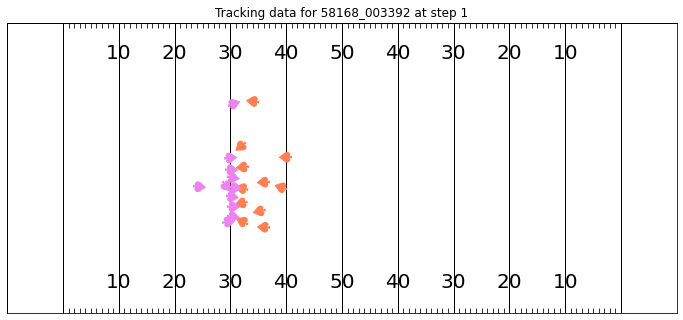

In [8]:
fig, ax = populate_field(play_name='58168_003392', step=1, player_tracking_data=train_player_tracking_data)
fig

In [9]:
# arguments
play_name = '58168_003392'
data = train_player_tracking_data.copy()

# total number of frames at 10hz
frames = len(data.query("game_play==@play_name")['step'].unique())

# frequency modifier factor [min_val:1, max_val:10] (reduce this for smoother tracking but longer rendering time)
freq_mod_fac = 5
# to reduce rendering time we change the frequency to (10/freq_mod_fac)Hz
frames = int(frames/freq_mod_fac)
interval_ms = 100*freq_mod_fac


# initialize figure
fig, ax = plt.subplots(figsize=(12, 5.33))
fig, ax = create_football_field(fig, ax)

def animate(i:int, play_name:str, player_tracking_data:pd.DataFrame, frames, home_color:str='violet', away_color:str='coral'):
    """
    Function to animate player tracking data
    """
    # create fresh field
    ax.clear()
    create_football_field(fig, ax)
    
    # find appropriate
    play_info = player_tracking_data.query("game_play==@play_name").copy()
    step_list = np.linspace(play_info['step'].min(), play_info['step'].max(), frames)
    step = int(step_list[i])
    
    # subset data to step info
    step_info = play_info.query("step==@step").copy()
    
    # iterate step info to populate field
    for row in step_info.iterrows():
        if row[1]['team'] == 'home':
            color = home_color
        else:
            color = away_color
        marker1 = MarkerStyle(r'$\spadesuit$')
        marker1._transform.rotate_deg(360-row[1]['orientation'])
        ax.scatter(row[1]['x_position'], row[1]['y_position'], marker=marker1, s=150, color=color)
    
    # set axis title
    ax.set_title(f'Tracking data for {play_name} at step {step}')

# animate
anim = animation.FuncAnimation(fig, animate, fargs=(play_name, data, frames),frames=frames, repeat=False, interval=interval_ms)

# embed html video to notebook
video = anim.to_html5_video()
html = IPython.display.HTML(video)
display(html)
plt.close()
